# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [286]:
# import libraries here; add more as necessary
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.shape

(891221, 85)

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info.shape

(85, 4)

In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SHOPPER_TYP,person,ordinal,[-1]
freq,1,43,49,26


In [10]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [11]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [12]:
# We dont do this inplace to keep idempotency, and to cache the values
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [15]:
def clean(x, name):
    nan_indicators = feat_info[feat_info['attribute'] == name].iloc[0].missing_or_unknown
    return x.map(lambda z: np.nan if str(z) in nan_indicators else z) 

In [16]:
# This will run an operataion on each column, clean, which will then apply a map on the series to replace
# any missing values with np.nan
azdias_clean = azdias.apply(lambda x: clean(x, x.name), axis=0)

In [17]:
azdias_clean.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Lets compare our original dataset, before cleaning
azdias.isnull().sum()

AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64

In [19]:
# And after cleaning, we can see we have successfully replaced missing/unknown
# indicators with the correct np.nan values
azdias_clean.isnull().sum()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64

In [20]:
nan_vals = azdias_clean.isnull().sum() / len(azdias_clean)

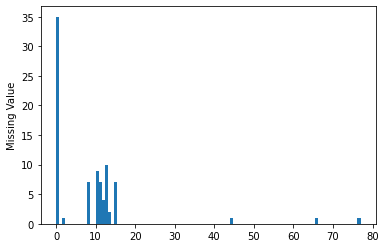

In [21]:

plt.hist(nan_vals * 100, bins=100)
plt.ylabel('Missing Value')
plt.show()

<BarContainer object of 85 artists>

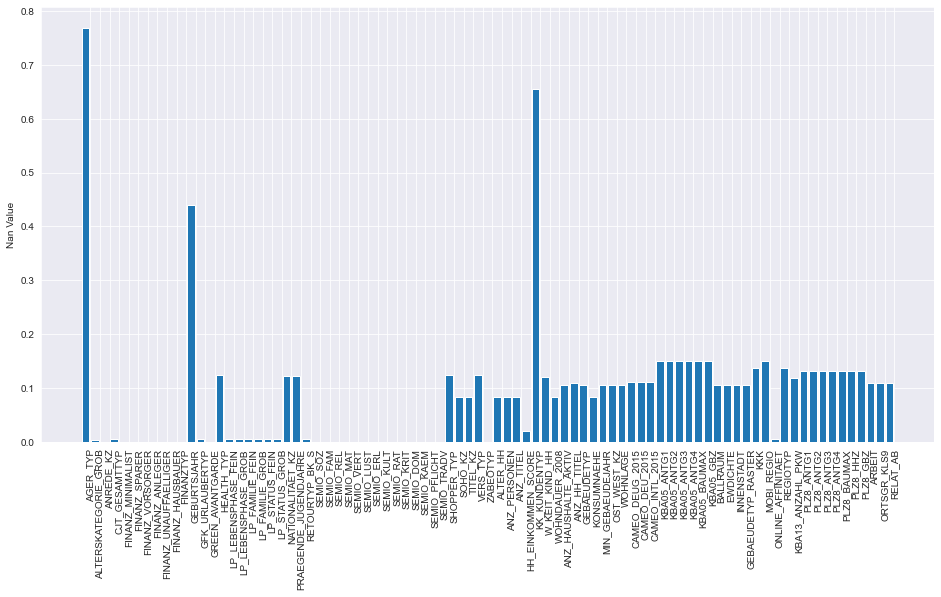

In [165]:
#### Investigate patterns in the amount of missing data in each column.
# credit to https://www.kaggle.com/cgump3rt/investigate-missing-values, for help with now to plot stuff.
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(nan_vals)) + 0.5, nan_vals.index, rotation='vertical')
plt.ylabel('Nan Value')
plt.bar(np.arange(len(nan_vals)), nan_vals)

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_cols = ['AGER_TYP', 'GEBURTSJAHR', 'KK_KUNDENTYP']
azdias_clean = azdias_clean.drop(columns=drop_cols)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Upon reviewing the data, both before and after our data cleaning, there are 3 observed columns that have a significant amount of missing data when compared to the rest of the features in the set.

- AGER_TYP: This column has  rows, with **685843** values deemed missing or unknown, or **76.9554%**
- GEBURTSJAHR: This column has 891221 rows, with **392318** values deemed missing or unknown, or **44.0202%**.
- KK_KUNDENTYP: This column has 891221 rows, with **584612** values deemed missing or unknown, or **65.5967%**.

With these columns having such a large amount of data irrelevant, we can disregard these columns as to not influence our results negativly.

In [333]:
azdias_clean.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
 azdias_clean.isnull().sum(axis=1)

0         46
1          0
2          0
3          1
4          0
          ..
891216     3
891217     4
891218     1
891219     0
891220     0
Length: 891221, dtype: int64

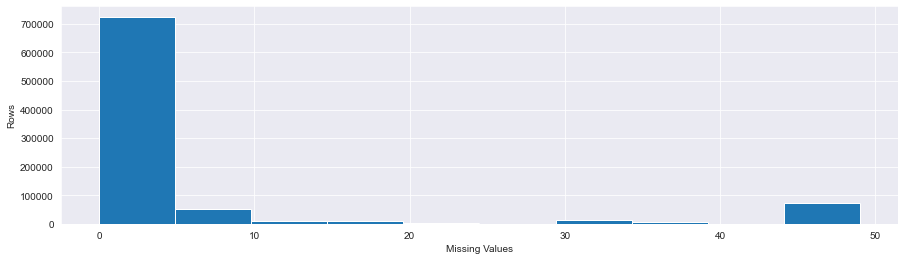

In [231]:
# How much data is missing in each row of the dataset?
null_values = azdias_clean.isnull().sum(axis=1)

plt.figure(figsize=(15,4))
plt.hist(null_values)
plt.ylabel('Rows')
plt.xlabel('Missing Values')
plt.show()

In [184]:
print('Null Counts Less than threshold')
print('---')
print(' <= 2')
print((azdias.isnull().sum(axis=1) <= 2).value_counts())
print('--')
print(' <= 3')
print((azdias.isnull().sum(axis=1) <= 3).value_counts())
print('--')
print(' <= 4')
print((azdias.isnull().sum(axis=1) <= 4).value_counts())
print('--')
print(' <= 5')
print((azdias.isnull().sum(axis=1) <= 5).value_counts())
print('--')
print(' <= 6')
print((azdias.isnull().sum(axis=1) <= 6).value_counts())
print('--')
print(' <= 7')
print((azdias.isnull().sum(axis=1) <= 7).value_counts())
print('--')

Null Counts Less than threshold
---
 <= 2
True     730306
False    160915
dtype: int64
--
 <= 3
True     738373
False    152848
dtype: int64
--
 <= 4
True     743518
False    147703
dtype: int64
--
 <= 5
True     743870
False    147351
dtype: int64
--
 <= 6
True     743997
False    147224
dtype: int64
--
 <= 7
True     752162
False    139059
dtype: int64
--


### Analysis

Based on our above graph, of rows with missing values, we can divide our data based on having <= 10 null values per row and those that are greater.

In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_lt = azdias_clean[azdias_clean.isnull().sum(axis=1) <= 10]
azdias_gt = azdias_clean[azdias_clean.isnull().sum(axis=1) > 10]


In [25]:
azdias_clean_missing_mask = (azdias_clean.isnull().sum() / len(azdias_clean)) * 100

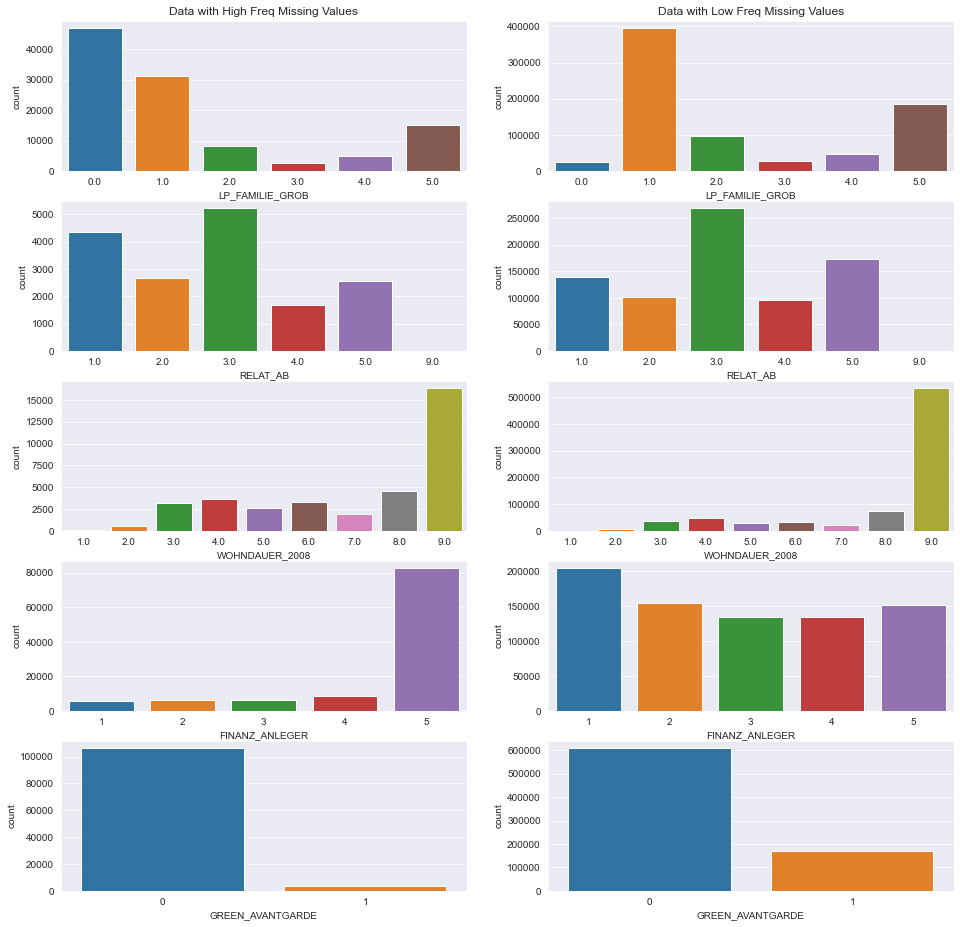

In [229]:
random_columns = np.random.choice(azdias_clean.columns, size = (5,))
plot_index = 1
plt.figure(figsize = (16, 16))

for c in random_columns:
    plt.subplot(5, 2, plot_index)
    sns.countplot(azdias_gt[c])
    
    if plot_index == 1:
        plt.title('Data with High Freq Missing Values')
    
    plt.subplot(5, 2, plot_index + 1)
    sns.countplot(azdias_lt[c])
    
    if plot_index == 1:
        plt.title('Data with Low Freq Missing Values')
    
    plot_index += 2

#### Discussion 1.1.3: Assess Missing Data in Each Row

The 'Missing Values' histogram plot above is displaying missing features per row.  We can cleary see that there is large porportion of rows that have 10 or less missing columns.  Although we could limit this to 5 I think that 10 should give us a clear picture of the data at hand, given that there are 78 feature columns in out dataset.  


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [236]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [198]:
#azdias_formatted = azdias_clean.copy(deep=True)

# We will be using our data that we defined to have few mising values
azdias_formatted = azdias_lt.copy(deep=True)

In [141]:
azdias_formatted.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Get a subset of our feature columns that are known of type categorical
categorical_columns = feat_info[feat_info['type'] == 'categorical']['attribute'].values

In [256]:
categorical_columns

array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [29]:
cat_types = {
    'binary': [],
    'multi-level': []
}

In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.

for c in categorical_columns:
    if not c in azdias_formatted:
        continue
    if azdias_formatted[c].nunique() == 2:
        cat_types['binary'].append(c)
    else:
        cat_types['multi-level'].append(c)

In [142]:
# Print our divided columns
print(f'Binary {cat_types["binary"]}')
print('')
print(f'multi-level {cat_types["multi-level"]}')

Binary ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

multi-level ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [143]:
[azdias_formatted[c].value_counts() for c in cat_types['binary']]

[2    407322
 1    374077
 Name: ANREDE_KZ, dtype: int64,
 0    609569
 1    171830
 Name: GREEN_AVANTGARDE, dtype: int64,
 0.0    774837
 1.0      6562
 Name: SOHO_KZ, dtype: int64,
 2.0    389981
 1.0    356813
 Name: VERS_TYP, dtype: int64,
 W    615734
 O    165665
 Name: OST_WEST_KZ, dtype: int64]

In [199]:
azdias_formatted['OST_WEST_KZ'].isnull().sum()

0

In [200]:
azdias_formatted.shape

(781399, 82)

In [239]:
# Once reviewing our binary features, there is 1 that is binary in nature but with non numerical data, OST_WEST_KZ
# We can onehot encode this column
print(azdias_formatted['OST_WEST_KZ'].value_counts())

1    615734
0    165665
Name: OST_WEST_KZ, dtype: int64


In [240]:
azdias_formatted['OST_WEST_KZ'].replace(["W", "O"], [1, 0], inplace=True)


TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

## Encoding Multi-Level Cateogorial Data

In [204]:
# Lets remove cols we have already dropped
multi_cats = [x for x in cat_types['multi-level'] if x in azdias_formatted]

azdias_formatted = pd.get_dummies(data=azdias_formatted, columns=multi_cats, prefix=multi_cats)

In [205]:
# Here we have a full dataframe with our one-hot encoded features.
azdias_formatted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781399 entries, 1 to 891220
Columns: 204 entries, ALTERSKATEGORIE_GROB to CAMEO_DEU_2015_9E
dtypes: float64(44), int64(23), object(1), uint8(136)
memory usage: 512.7+ MB


In [39]:
azdias_formatted['LP_STATUS_GROB_2.0']

1         0
2         1
3         0
4         1
5         1
         ..
891216    0
891217    0
891218    1
891219    0
891220    0
Name: LP_STATUS_GROB_2.0, Length: 781399, dtype: uint8

----

#### Discussion 1.2.1: Re-Encode Categorical Features

We have `10` binary categorical features and `30` multi level categorical features.  Of these `10` binary features, `1` was a non numerical features, 'OST_WEST_KZ'.  For this we mapped its values W, O to 1 and 0 respectivly.  

As for the multi-level categorical features, we also performed one hot encoding on these as well.  We then dropped the original columns from the dataset.  My goal was to perserve as much as the data initially as we can, so I did not drop any of the categorical columns at this time, outside of the original columns once they have been one hot encoded.  If there proves to be an issue with any of these columns we can go back and remove them as necessary.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [206]:
azdias_formatted.shape

(781399, 204)

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# 1 var for generation (40s, 50s, 60s) and one for movement (avant, main)

# Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
# - -1: unknown
# -  0: unknown
# -  1: 40s - war years (Mainstream, E+W)
# -  2: 40s - reconstruction years (Avantgarde, E+W)
# -  3: 50s - economic miracle (Mainstream, E+W)
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
# -  5: 60s - economic miracle (Mainstream, E+W)
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
# -  8: 70s - family orientation (Mainstream, E+W)
# -  9: 70s - peace movement (Avantgarde, E+W)
# - 10: 80s - Generation Golf (Mainstream, W)
# - 11: 80s - ecological awareness (Avantgarde, W)
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# - 13: 80s - Swords into ploughshares (Avantgarde, E)
# - 14: 90s - digital media kids (Mainstream, E+W)
# - 15: 90s - ecological awareness (Avantgarde, E+W)

AVANT, MAIN = 1, 2
forty, fifty, sixty, seventy, eighty, ninty = 1, 2, 3, 4, 5, 6

generation = { 
    1: (forty, MAIN), 2: (forty, AVANT), 3: (fifty, MAIN), 4: (fifty, AVANT), 5: (sixty, MAIN),
    6: (sixty, AVANT), 7: (sixty, AVANT), 8: (seventy, MAIN), 9: (seventy, AVANT), 10: (eighty, MAIN),
    11: (eighty, AVANT), 12: (eighty, MAIN), 13: (eighty, AVANT), 14: (ninty, MAIN), 15: (ninty, AVANT)
             }

def map_praegende_gen(value):
    if value in generation:
        return generation[int(value)][0]
    
def map_praegende_movement(value):
    if value in generation:
        return generation[int(value)][1]


In [207]:
azdias_formatted['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    178663
8.0     138903
10.0     83974
5.0      83740
3.0      53177
15.0     41067
11.0     34668
9.0      33228
6.0      25531
12.0     24059
4.0      20353
1.0      20350
2.0       7454
13.0      5562
7.0       3967
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [208]:
azdias_formatted['PRAEGENDE_JUGENDJAHRE_GENERATION'] = azdias_formatted['PRAEGENDE_JUGENDJAHRE'].apply(map_praegende_gen)
azdias_formatted['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_formatted['PRAEGENDE_JUGENDJAHRE'].apply(map_praegende_movement)



In [209]:
azdias_formatted['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].isnull().sum()

26703

In [210]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_formatted['CAMEO_INTL_2015'].value_counts()

wealthy, prosp, comfort, less_aff, poor = 1, 2, 3, 4, 5
pre_fam, young_cou, fam, old, eld = 1, 2, 3, 4, 5

def format_cameo_value(val):
    if pd.isnull(val):
        return
    return int(val) // 10**1 % 10

def format_cameo_family_type(val):
    if pd.isnull(val):
        return
    return int(val) // 10**0 % 10

format_cameo_value(np.nan)

In [211]:
azdias_formatted['CAMEO_INTL_2015_WEALTH'] = azdias_formatted['CAMEO_INTL_2015'].apply(format_cameo_value)
azdias_formatted['CAMEO_INTL_2015_LIFESTAGE'] = azdias_formatted['CAMEO_INTL_2015'].apply(format_cameo_family_type)

azdias_formatted['CAMEO_INTL_2015_LIFESTAGE'].value_counts()

1.0    242082
4.0    228775
3.0    115581
5.0    115403
2.0     75825
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: int64

In [212]:
azdias_formatted = azdias_formatted.drop(columns=['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'])

#### Discussion 1.2.2: Engineer Mixed-Type Features


We have 2 features in our data set that are mixed type features, these are PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.  By having sufficient information on how to map these values to relevant data, we were able to encode both these features into 4 new features, 2 and 2 respectivly.  We were able to map these new feature columns using `apply()` function of the dataframe to apply a function to each column series.  


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [213]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
print(azdias_formatted.info())
print(f'Value Types in our Data: {np.unique(azdias_formatted.dtypes.values)}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781399 entries, 1 to 891220
Columns: 206 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(47), int64(23), uint8(136)
memory usage: 524.6 MB
None
Value Types in our Data: [dtype('uint8') dtype('int64') dtype('float64')]


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [319]:
def clean_attr2(x, name):
    attr = feat_info[feat_info['attribute'] == name]
    
    # if the row DNE, return early
    if len(attr) == 0:
        return
    
    nan_indicators = attr.iloc[0].missing_or_unknown
    return x.map(lambda z: np.nan if str(z) in nan_indicators else z) 

In [320]:
def clean_data2(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = df.apply(lambda x: clean_attr2(x, x.name), axis=0)
    
    # remove selected columns and rows, ...
    drop_cols = ['AGER_TYP', 'GEBURTSJAHR', 'KK_KUNDENTYP']
    df = df.drop(columns=drop_cols)
    
    # Limit our data to rows with few missing features
    # df = df[df.isnull().sum(axis=1) > 10]

    # select, re-encode, and engineer column values.
    categorical_columns = feat_info[feat_info['type'] == 'categorical']['attribute'].values
    cat_types = {
        'binary': [],
        'multi-level': []
    }
    for c in categorical_columns:
        if not c in df:
            continue
        if df[c].nunique() == 2:
            cat_types['binary'].append(c)
        else:
            cat_types['multi-level'].append(c)
    
    df['OST_WEST_KZ'].replace(["W", "O"], [1, 0], inplace=True)  
    
    # Lets remove cols we have already dropped
    multi_cats = [x for x in cat_types['multi-level'] if x in df]

    df = pd.get_dummies(data=df, columns=multi_cats, prefix=multi_cats)
    
    # Process our 2 multi level features
    df['PRAEGENDE_JUGENDJAHRE_GENERATION'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_praegende_gen)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_praegende_movement)
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(format_cameo_value)
    df['CAMEO_INTL_2015_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(format_cameo_family_type)
    
    df = df.drop(columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'])

    # Return the cleaned dataframe.
    return df    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [216]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# For now, we are going to drop rows with missing data
# azdias_formatted = azdias_formatted.dropna()

azdias = azdias_formatted.loc[:,~azdias_formatted.columns.duplicated()]


imputer = SimpleImputer(strategy='median')
imputer_data = imputer.fit_transform(azdias)

In [217]:
azdias.shape

(781399, 206)

In [218]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
standardized_data = scaler.fit_transform(imputer_data)

### Discussion 2.1: Apply Feature Scaling

~~When it comes to missing data, I opted for the quick approach of dropping data with missing values~~.  

Upon nearing the final conclusion of this notebook, I had to come back here and make some adjustments.  I originally opted to drop rows with missing data, but after further review I used SimpleImputer instead.

This is a first attempt to get to the point where we are starting to look at our data points.  ~~Using an Imputer is not out of the realm of possibility at this point, but I opted for simpler.~~

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [219]:
# Apply PCA to the data.
pca = PCA()
pca_features = pca.fit_transform(standardized_data)

In [220]:
len(pca.components_)

206

Text(0.5, 1.0, 'Explained Variance Per Principal Component: 206 Components')

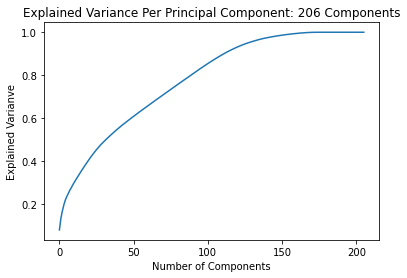

In [221]:
# Investigate the variance accounted for by each principal component.
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Varianve')
plt.title('Explained Variance Per Principal Component: 206 Components')

In [222]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_100 = PCA(100)
X_pca_100 = pca_100.fit_transform(standardized_data)

In [223]:
# What is our total variance with 100 components?
print(sum(pca_100.explained_variance_ratio_ * 100))

84.66528411500116


Text(0.5, 1.0, 'Explained Variance Per Principal Component: 100 Components')

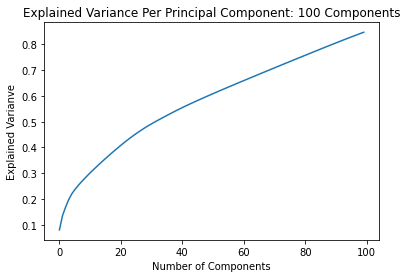

In [224]:
# Investigate the variance accounted for by each principal component.
#scree_plot(pca, 'Explained Variance Per Principal Component: 100/205')

plt.plot(np.cumsum(pca_100.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Varianve')
plt.title('Explained Variance Per Principal Component: 100 Components')

Text(0.5, 1.0, 'Scaled Data by PCA: ~84%')

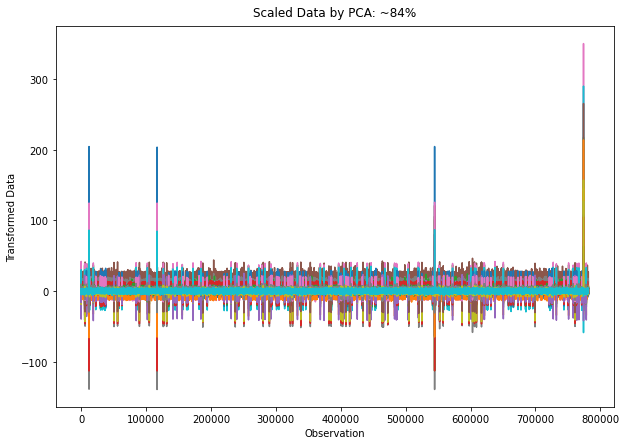

In [225]:
plt.figure(figsize=(10,7))
plt.plot(X_pca_100)
plt.xlabel('Observation')
plt.ylabel('Transformed Data')
plt.title('Scaled Data by PCA: ~84%', pad=10)

## For sake of curiosity

In [226]:
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(standardized_data)
print(sum(pca_2.explained_variance_ratio_ * 100))

13.544393370488944


### Discussion 2.2: Perform Dimensionality Reduction


After performing PCA on our dataset, we identified 477 components.  By reducing this down to 100 out of the original 477 we can still maintain about 84.81% explained variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [62]:
df = pd.DataFrame(np.round(pca_100.components_, 4), columns=azdias.keys())
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_GENERATION,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,-0.0678,0.0137,-0.1770,0.0978,-0.0688,0.0398,0.0405,0.1462,-0.0988,0.0189,...,0.0257,0.0351,0.0546,0.0563,0.0556,0.0182,0.0558,0.0988,0.1782,-0.1046
1,0.2369,0.0357,0.1039,-0.2334,0.2232,-0.2068,-0.2151,0.0713,0.0028,-0.0530,...,0.0322,-0.0102,-0.0026,0.0019,0.0078,0.0373,-0.2421,-0.0028,0.0404,0.0208
2,0.0137,-0.3356,0.1316,-0.0551,0.0451,-0.1549,-0.0435,-0.0677,0.0960,-0.0041,...,-0.0006,-0.0034,0.0122,0.0253,0.0118,-0.0021,-0.0449,-0.0960,0.0129,-0.0136
3,-0.0056,0.1096,-0.0121,0.0026,-0.0043,-0.0305,0.0181,-0.0072,0.1904,-0.0079,...,-0.0024,0.0144,0.0032,0.0070,0.0052,0.0020,0.0243,-0.1904,-0.0122,0.0040
4,0.0522,-0.0522,0.0152,-0.0266,0.0439,0.0391,-0.1045,0.0137,-0.2421,-0.0037,...,0.0299,0.0538,0.0317,0.0173,0.0222,-0.0019,-0.0311,0.2421,0.1410,-0.0762


In [227]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
# (ref at bottom of notebook, had to find some help on plotting this due to limited skill on this stuff)

def visualize_pca(data, pca, loc):
    df = pd.DataFrame(np.round(pca.components_, 4), columns=data.keys()).iloc[loc - 1]
    df.sort_values(ascending=False, inplace=True)
    df = pd.concat([df.head(3), df.tail(3)])
    df.plot(kind='bar', title='Component ' + str(loc))
    p = plt.gca()
    p.set_axisbelow(True)
    
    plt.show()


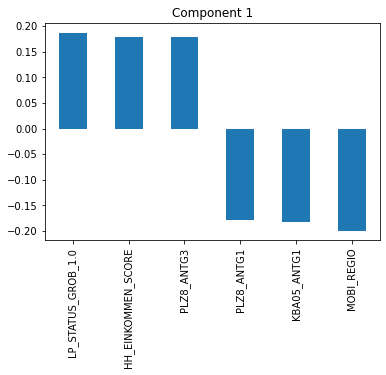

In [228]:
visualize_pca(azdias, pca_100, 1)

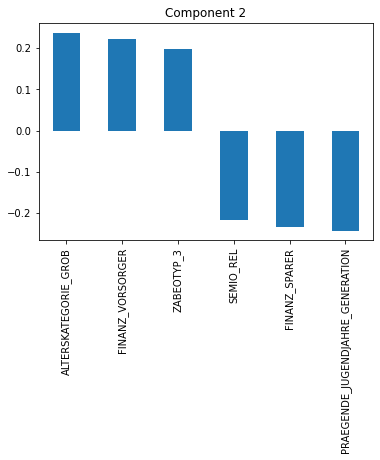

In [229]:
visualize_pca(azdias, pca_100, 2)

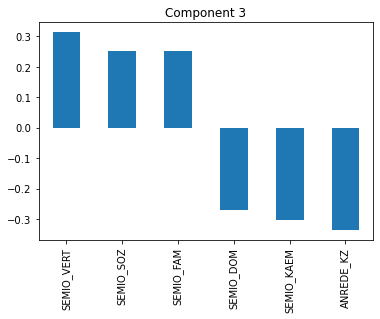

In [230]:
visualize_pca(azdias, pca_100, 3)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

### 1. Component 1

Top Features:

 - `LP_STATUS_GROB`: `person`: `categorical`
     - This feature refers to "social status, rough scale". This feature maps earner income from (1) low-income to (5) top earner.  This is a "rougher" more generic feature as compared to a similar feature `LP_STATUS_FEIN`, which is a more granular fine grained breakdown of social status.
 - `HH_EINKOMMEN_SCORE` 
     - This feature refers to estimated household income, ranging from (1) highest income to (6) very low income.
 - `CAMEO_INTL_2015_WEALTH`
     - This feature is one of our added onehot encoded features.  The base feature is CAMEO_INTL_2015, which is "Wealth / Life Stage Typology".  This particular feature, WEALTH, refers to the economic status.  This ranges from (1) Wealthy Households to (5) Poorer Households
     

Bottom Features:

- `FINANZ_MINIMALIST` 
    - This feature refers to financial typlogy, particularly low financial interest
    
- `KBA05_ANTG1`
    - This feature refers to "Number of 1-2 family houses in microcell"
    
- `MOBI_REGIO`
    - This feature refers to "Movement Patterns".  With (1) being very high movement to (5) very low movement and (6) none.

>>> With this component we see a trend with wealth and economic status, with each feature having to do with money and wellbeing.
     
### 2. Component 2

Top Features:

- `ALTERSKATEGORIE_GROB`
    - This feature refers to estimated age base on analysis.

- `FINANZ_VORSORGER`
    - This feature refers to financial typology.
    
- `ZABEOTYP`
    - This feature refers to "Energy Consumption"  With (1) being unknwown, (2) being 'green' all the way to (6) 'indifferent' and (9) unknown.
    
Bottom Features:

- `SEMIO_REL`
    -  This feature refers to Personality typology.  
    
- `FINANZ_SPARER`
    - This feature refers to financial typology.  In this case we refer to "money-save".

- `PRAEGENDE_JUGENDJAHRE_GENERATION`
    - This feature is an encoded feature from the base `PRAEGENDE_JUGENDJAHRE`.  This refers to "Dominating movement of person's youth (avantgarde, vs mainstream, east vs west).  In this particular feature we look to generation, specifically 40s, 50s, 60s, 70s, 80s and 90s.
    
    

As we review the first top components of our Principal Component Analysis, the driving features seem to be about economic status and wealth and income.  These seem to drive a lot of the conclusions around the data.  By reviewing the bottom features of the first two components we see some similiarly grouped data around finance, but in this case its about not caring to much about it.  Minimal interest in finance and "money" savers.  There is also some similar data in the realm of movement, where did you live, do you move much, etc.


----

In [66]:
def plot_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure();
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [69]:
# Over a number of different cluster counts...
scores = []
centers = list(range(1, 50))
sample = X_pca_100[np.random.choice(X_pca_100.shape[0], int(X_pca_100.shape[0] * 0.20), replace=False)]

for center in centers:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(sample)
    labels = model.predict(sample)
    
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(sample))
    scores.append(score)
    

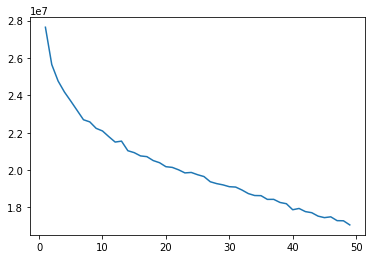

In [70]:
plt.plot(centers, scores)

In [231]:
# Refitting the dataset with our 30 clusters

kmeans = KMeans(n_clusters=30)
model = kmeans.fit(X_pca_100)
labels = model.predict(X_pca_100)

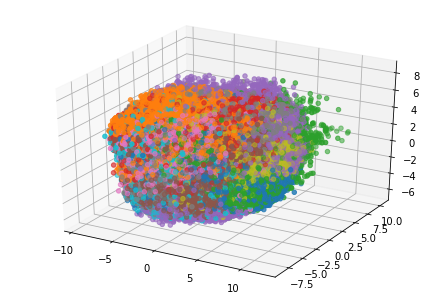

In [232]:
plot_data(X_pca_100, labels)

### Discussion 3.1: Apply Clustering to General Population


For this task I reduced the dataset down to 33% or the original data, then later down to 20%.  I ran a genric loop from 1 to 50 and ran the KMeans algorithm on the data with the loop index indicating the number of clusters to use.  I then printed these all out and saved them to a list.  Upon review of the cluster scoring, I was happy with 30 clusters being good to use going forward.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [233]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [126]:
print(customers.shape)
customers.head()

(191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [127]:
def clean_attr2(x, name):
    attr = feat_info[feat_info['attribute'] == name]
    
    # if the row DNE, return early
    if len(attr) == 0:
        return
    
    nan_indicators = attr.iloc[0].missing_or_unknown
    return x.map(lambda z: np.nan if str(z) in nan_indicators else z) 

In [242]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_processed = clean_data2(customers.copy(deep=True))

In [243]:
print(f'azdias cols: {len(azdias.columns)}.  Customer Cols: {len(customer_processed.columns)}')

azdias cols: 206.  Customer Cols: 204


In [244]:
# Compare our two dataframes for difference
list(set(azdias.columns) - set(customer_processed.columns))

['GEBAEUDETYP_5.0', 'TITEL_KZ_2.0']

In [245]:
# The customer data does not have values 5 for GEBAEUDETYP and 2 for TITEL_KZ.
# These columns DNE since our one hot encoding would generate these based on values in the row.  
# We need consistent datashape to proceed.
customers_copy = customers.copy(deep=True)
customers_copy['GEBAEUDETYP_5.0'] = 0
customers_copy['TITEL_KZ_2.0'] = 0

In [246]:
customers_copy['TITEL_KZ_2.0'].value_counts()

0    191652
Name: TITEL_KZ_2.0, dtype: int64

In [247]:
print(customers_copy.shape)

# Rerun our new edited DF through our clean function
customer_processed = clean_data2(customers_copy)
print(customer_processed.shape)

(191652, 87)
(191652, 206)


In [248]:
#### Confirm data is same
list(set(customer_processed.columns) - set(azdias.columns))


[]

In [249]:
customer_processed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_GENERATION,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,2.0,1.0,1.0,3.0
1,4.0,1,5,1,5,1,3,2,0,1.0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,2.0,1.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0,0,1.0,2.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0,4.0,2.0,4.0,1.0


In [250]:
# As found above, there are the same indexes on each dataframe

# Note, originally we were dropping na, but we cant do that with the customer data set.
# So I had to go back to the original fitting and adjust how we handled nan
# customer_processed = customer_processed.dropna()

imputer_data = imputer.transform(customer_processed)

In [251]:
customer_processed.shape

(191652, 206)

In [252]:
standardized_data = scaler.fit_transform(imputer_data)

In [288]:
X_pca_customer = pca_100.transform(standardized_data)

In [291]:
customer_kmeans_labels = kmeans.predict(X_pca_customer)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

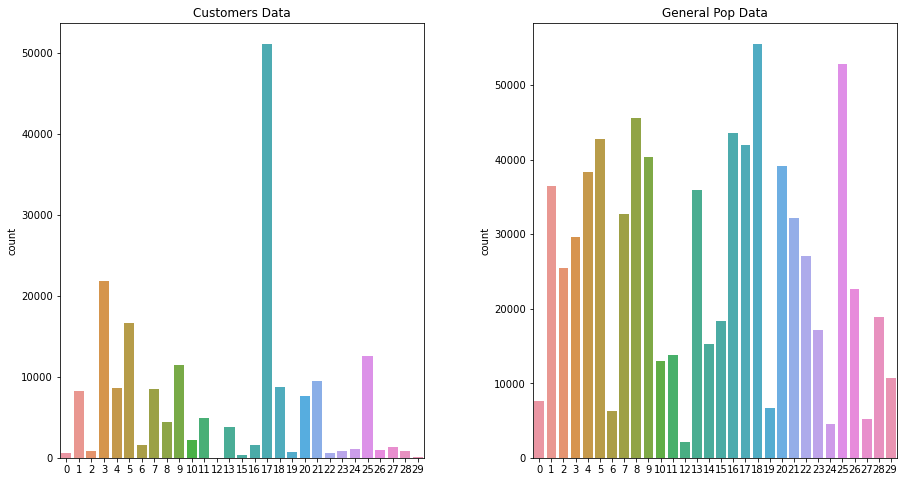

In [292]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace = 1, wspace=.3)
plt.subplot(121)

sns.countplot(customer_kmeans_labels)

plt.title('Customers Data')
plt.subplot(122)
sns.countplot(labels)

plt.title('General Pop Data')
plt.show()

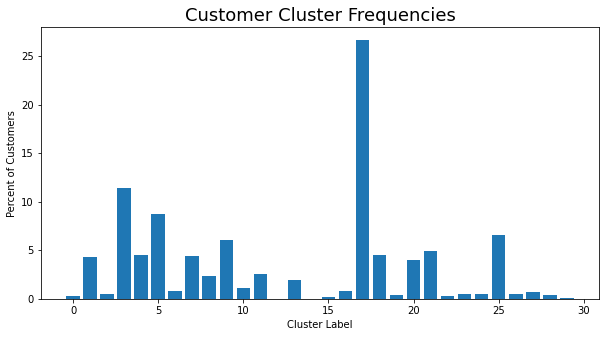

In [296]:
counts_customer = Counter(customer_kmeans_labels)
n_customers = X_pca_customer.shape[0]

customer_freqs = {label: 100*(freq / n_customers) for label, freq in counts_customer.items()}
plt.figure(figsize = (10, 5));
plt.bar(customer_freqs.keys(), customer_freqs.values());
plt.title('Customer Cluster Frequencies', fontsize = 18);
plt.xlabel('Cluster Label');
plt.ylabel('Percent of Customers');

In [317]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid = scaler.inverse_transform(pca_100.inverse_transform(model.cluster_centers_[17]))
b = pd.Series(centroid, index=customer_processed.columns)
b.head(10)

ALTERSKATEGORIE_GROB     2.093397
ANREDE_KZ                1.814761
FINANZ_MINIMALIST        2.916143
FINANZ_SPARER            3.385651
FINANZ_VORSORGER         3.292351
FINANZ_ANLEGER           4.347848
FINANZ_UNAUFFAELLIGER    4.199011
FINANZ_HAUSBAUER         3.130262
GREEN_AVANTGARDE         0.180336
HEALTH_TYP               1.982927
dtype: float64

In [318]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid = scaler.inverse_transform(pca_100.inverse_transform(model.cluster_centers_[1]))
b = pd.Series(centroid, index=customer_processed.columns)
b.head(10)

ALTERSKATEGORIE_GROB     3.711531
ANREDE_KZ                1.597270
FINANZ_MINIMALIST        3.902063
FINANZ_SPARER            1.289114
FINANZ_VORSORGER         4.740248
FINANZ_ANLEGER           2.489613
FINANZ_UNAUFFAELLIGER    1.543146
FINANZ_HAUSBAUER         3.482416
GREEN_AVANTGARDE         0.149575
HEALTH_TYP               1.873302
dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data


For our final analysis of the customer data to demographic data, I used clusters 17 as one that was overrepresented and 1 as a cluster that was underrepresented.  In cluster 17, ALTERSKATEGORIE_GROB has a value of 2.09 compared to that of cluster 1 which has a value of 3.71.  ALTERSKATEGORIE_GROB representes estimated age.  Using this information we can theorize that cluster 17 contains a younger population.  Cluster 17, according to FINANZ_MINIMALIST (financial typology), has a value of 2.9 compared to 3.9 which leads us to concur that cluster 17 has more population with high degree of minimalist living.  Cluster 1 tends to point towards a more average/low degree of minimalism.  Looking at a another feature, FINANZ_UNAUFFAELLIGER (Less conspicuous finance), cluster 17 has a value of 4.199 which is defined low compared to 1.54 in cluster 1 which is defined as very high.



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

[ref](https://github.com/JMarcan/unsupervised_learning_customer_segments/blob/master/Identify_Customer_Segments.ipynb) - For building out subplots, as I have had no expierence in charting data.

[ref 2](https://github.com/2667schummr/identify-customer-segments/blob/master/identify_customer_segments.ipynb) Reference for basic charting of clusters.

https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0